In [57]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import os.path
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
from pandas.tseries.offsets import MonthEnd
import math
from scipy.optimize import curve_fit

In [164]:
cm = 1 / 2.54  # inches to cm
wu = 16*cm  # width unit
hu = 8*cm  # height unit

LEAST_SIZE = 7
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def mark_axes(ax_tuple, px=-0.1, py=1.15):
    letter = "a"
    for ax in ax_tuple:
        ax.text(px, py, "(%s)" % letter, transform=ax.transAxes, fontsize=12, va='top', ha='right')
        letter = chr(ord(letter) + 1)  # increments the letter in alphabetical order

#### A simple linear regression with two predictors:
$$
B_{a} = B_{s} + B_{w}
$$
$$
B_{a} = k_{1} PDD + k_{2} P_{solid},
$$
where $k_{1}$ is a negative degree-day factor, and $k_{2}$ is a positive precipitation-scaling factor.

In [58]:
def lin_reg(x, a):
    # without any intercept
    return a * x

#### Vestre Groenfjordbreen - finding regression coefficients:

K2 = 1.95 [dimensionless]
K1 = -2.64 mm w.e. per day


(-2.2, 0.0)

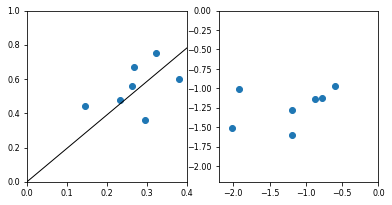

In [84]:
in_file = os.path.join(globals()['_dh'][0], "data/Vestre_sensitivity.csv")
fig_dir = os.path.join(globals()['_dh'][0], "fig")

df = pd.read_csv(in_file, encoding="cp1252")
# tmp.info()
# display(tmp)

df["PSOLID"] = df["PSOLID"] / 1000  # mm to m conversion

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(1*wu, 1*hu)

# plotting winter balance versus solid precipitation, both in meters w.e.:
ax[0].scatter(df["PSOLID"], df["BW"])
ax[0].set_xlim(0, 0.4)
ax[0].set_ylim(0, 1)

# computing and visualizing a simple linear regression:
# k2, intercept = np.polyfit(df["PSOLID"], df["BW"], 1)  # polyfit can't be forced to have a zero intercept
popt, pcov = curve_fit(lin_reg, df["PSOLID"], df["BW"])
k2 = popt[0]
print("K2 = %.2f [dimensionless]" % k2)

xrange = [0, 400]
fit = np.poly1d((k2, 0))
yrange = [fit(x) for x in xrange]
ax[0].plot(xrange, yrange, linewidth=1, color="k");

def fit_ba(X, k1):
    # regression with two predictors:
    pdd, psolid = X
    return k1 * pdd + k2 * psolid  # yep, we'll use previously find k2 here

popt, pcov = curve_fit(fit_ba, (df["PDD"], df["PSOLID"]), df["BA"])
k1 = popt[0]
print("K1 = %.2f mm w.e. per day" % (k1 * 1000))

def predict(pdd, psolid):
    return k1 * pdd + k2 * psolid

df["PREDICTED"] = predict(df["PDD"], df["PSOLID"])
# display(df)

ax[1].scatter(df["BA"], df["PREDICTED"])
ax[1].set_xlim(-2.2, 0)
ax[1].set_ylim(-2.2, 0)

#### Plotting the combined sensitivity chart:

Vestre Groenfjordbreen: [513.689356477264, 1243.668968313376]
Aldegondabreen: [519.0243902439025, 1256.5853658536587]


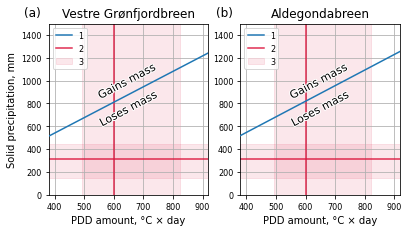

In [174]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(1*wu, 1*hu)

#######################################################################
# Vestre Groenfjordbreen:
pdd = [380, 920]
psolid = [k1 * x / -k2 * 1000 for x in pdd]  # 1000 is conversion to mm
print("Vestre Groenfjordbreen:", psolid)

ax[0].plot(pdd, psolid, label="1", zorder=3)
ax[0].set_title("Vestre Grønfjordbreen", fontsize=12)

#######################################################################
# Aldegondabreen:
psolid = [-2.8 * x / -2.05 for x in pdd]  # conversion to mm was already made
print("Aldegondabreen:", psolid)

ax[1].plot(pdd, psolid, label="1", zorder=3)
ax[1].set_title("Aldegondabreen", fontsize=12)

#######################################################################

for i in (0, 1):
    ax[i].grid()
    
    ax[i].set_xlim(380, 920)
    ax[i].set_ylim(0, 1500)

    rot = 28
    ax[i].text(0.30, 0.56, "Gains mass", color="k", fontsize=11, transform = ax[i].transAxes, rotation=rot, zorder=3,
                   path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    ax[i].text(0.31, 0.40, "Loses mass", color="k", fontsize=11, transform = ax[i].transAxes, rotation=rot, zorder=3,
                   path_effects=[pe.withStroke(linewidth=2, foreground="white")])

    ax[i].axvspan(492, 823, color="crimson", alpha=0.1, zorder=1, label=3)
    ax[i].axvline(600, color="crimson", alpha=0.9, zorder=2, label="2")

    ax[i].axhspan(145, 448, color="crimson", alpha=0.1, zorder=1)
    ax[i].axhline(310, color="crimson", alpha=0.9, zorder=2)

    ax[i].set_xlabel("PDD amount, °C × day")
    ax[0].set_ylabel("Solid precipitation, mm")
    ax[i].legend();
    
mark_axes(ax, px=-0.05, py=1.10)
#######################################################################

fig_paths = ("sensitivity_EN.png", "sensitivity_EN.pdf")
for fig_path in fig_paths:
    plt.savefig(os.path.join(fig_dir, fig_path), dpi=300, transparent=False, facecolor="white", bbox_inches='tight')

#### the same, russian version:

Vestre Groenfjordbreen: [513.689356477264, 1243.668968313376]
Aldegondabreen: [519.0243902439025, 1256.5853658536587]


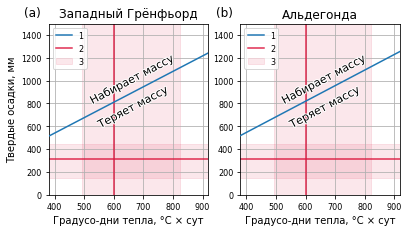

In [182]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(1*wu, 1*hu)

#######################################################################
# Vestre Groenfjordbreen:
pdd = [380, 920]
psolid = [k1 * x / -k2 * 1000 for x in pdd]  # 1000 is conversion to mm
print("Vestre Groenfjordbreen:", psolid)

ax[0].plot(pdd, psolid, label="1", zorder=3)
ax[0].set_title("Западный Грёнфьорд", fontsize=12)

#######################################################################
# Aldegondabreen:
psolid = [-2.8 * x / -2.05 for x in pdd]  # conversion to mm was already made
print("Aldegondabreen:", psolid)

ax[1].plot(pdd, psolid, label="1", zorder=3)
ax[1].set_title("Альдегонда", fontsize=12)

#######################################################################

for i in (0, 1):
    ax[i].grid()
    
    ax[i].set_xlim(380, 920)
    ax[i].set_ylim(0, 1500)

    rot = 28
    ax[i].text(0.25, 0.53, "Набирает массу", color="k", fontsize=11, transform = ax[i].transAxes, rotation=rot, zorder=3,
                   path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    ax[i].text(0.30, 0.39, "Теряет массу", color="k", fontsize=11, transform = ax[i].transAxes, rotation=rot, zorder=3,
                   path_effects=[pe.withStroke(linewidth=2, foreground="white")])

    ax[i].axvspan(492, 823, color="crimson", alpha=0.1, zorder=1, label=3)
    ax[i].axvline(600, color="crimson", alpha=0.9, zorder=2, label="2")

    ax[i].axhspan(145, 448, color="crimson", alpha=0.1, zorder=1)
    ax[i].axhline(310, color="crimson", alpha=0.9, zorder=2)

    ax[i].set_xlabel("Градусо-дни тепла, °C × сут")
    ax[0].set_ylabel("Твердые осадки, мм")
    ax[i].legend();
    
mark_axes(ax, px=-0.05, py=1.10)
#######################################################################

fig_paths = ("sensitivity_RU.png", "sensitivity_RU.pdf")
for fig_path in fig_paths:
    plt.savefig(os.path.join(fig_dir, fig_path), dpi=300, transparent=False, facecolor="white", bbox_inches='tight')